In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from datetime import datetime as datetime
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.sql import label

## Reflect Tables into SQLAlchemy ORM

In [2]:
database_path = "Resources/hawaii.sqlite"
# Create an engine that can talk to the database
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()


In [3]:
# reflect an existing database into a new model
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Step 1 - Climate Analysis and Exploration

## Precipitation Analysis

In [7]:
## Store Measurements and Stations to DataFrames
measurements = pd.read_sql("SELECT * FROM Measurement", conn)
stations = pd.read_sql("SELECT * FROM Station", conn)

In [8]:
# Perform a query to retrieve last 12 months of precipitation data and precipitation scores. 
# Choose a start date and end date for your trip. Make sure that your vacation range is approximately 3-15 days total.

travel_start_date = '2017-08-23'
travel_end_date = '2016-08-30'

# date 1 year ago from travel_date
year_ago = (datetime.strptime(travel_start_date, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d') 
print(f"Returning precipitation data from {year_ago} and {travel_start_date}")

# Save the query results as a Pandas DataFrame and set the index to the date column
year_precipitation_scores = pd.DataFrame(session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.date <= travel_start_date).\
    order_by(Measurement.date).all()).set_index('date')
year_precipitation_scores.head()

Returning precipitation data from 2016-08-23 and 2017-08-23


,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [9]:
# Sort the dataframe by date
year_precipitation_scores = year_precipitation_scores.sort_values(by='date', ascending=True)
year_precipitation_scores

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


In [15]:
# Drop rows where prcp=NaN
year_precipitation_scores = year_precipitation_scores.dropna().rename(columns={'prcp':'precipitation'})

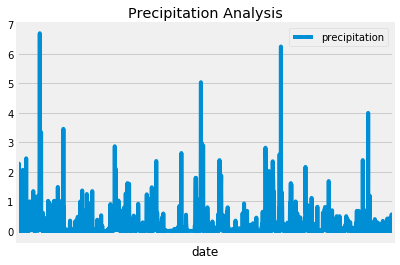

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_chart = year_precipitation_scores.plot(title='Precipitation Analysis',xticks=[])

#### Use Pandas to calcualte the summary statistics for the precipitation data

In [17]:
# For 1 year of the precipitation data
year_precipitation_scores.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [18]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station.station, Station.name).count()
print(f"There are total {total_stations} stations.")
all_stations = session.query(Station.station, Station.name).all()
all_stations

There are total 9 stations.


[('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00513117', 'KANEOHE 838.1, HI US'),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00517948', 'PEARL CITY, HI US'),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00519281', 'WAIHEE 837.5, HI US'),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US')]

In [19]:
# List the stations and the counts in descending order.
#station_obsv_counts = measurements.groupby('station')['prcp'].count().sort_values(ascending=False).reset_index()
station_obsv_counts = session.query(Measurement.station,label('total_prcp', func.count(Measurement.tobs))).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
station_obsv_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_with_obsv_max = station_obsv_counts[0][0]
station_obsv_max = station_obsv_counts[0][1]
print(f'Station # {station_with_obsv_max} has the highest, {station_obsv_max} observations.')

Station # USC00519281 has the highest, 2772 observations.


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(Measurement.station,label('lowest_temp', func.min(Measurement.tobs)),label('highest_temp', func.max(Measurement.tobs)),label('average_temp', func.avg(Measurement.tobs))).\
filter(Measurement.station == station_with_obsv_max).\
group_by(Measurement.station).all()


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station

year_temperature_observations = pd.DataFrame(session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.date <= travel_start_date).\
    filter(Measurement.station == station_with_obsv_max).\
    order_by(Measurement.date).all()).set_index('date')
year_temperature_observations

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


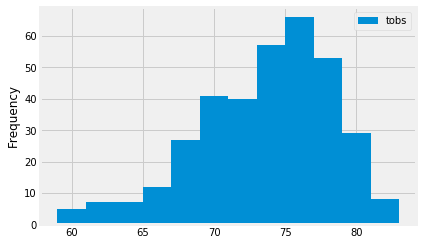

In [23]:
# Plot the results as a histogram
temperature_chart = year_temperature_observations.plot.hist(bins=12)

# Step 2 - Climate App

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps(year_ago, travel_start_date))

[(58.0, 74.59058295964125, 87.0)]


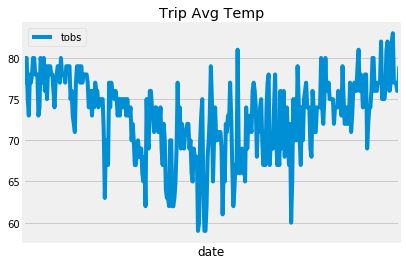

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

year_temperature_observations_chart = year_temperature_observations.plot(title="Trip Avg Temp",xticks=[])

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
